# Advanced Liquidity Models

Pre-compute advanced metrics for Power BI dashboard

In [36]:
import sys
sys.path.append('/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/scripts')
import advanced_models
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = '/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb'

## Run Advanced Models

In [37]:
results = advanced_models.main(DB_PATH)

Loading base metrics...
Loaded 1,252,799 rows

Calculating Kyle's Lambda...
Calculating Amihud Illiquidity...
Calculating Spread Decomposition...

Saving results to DuckDB...
Complete!


## Kyle's Lambda Results

Kyle's Lambda by Segment:


,segment_id,kyle_lambda,lambda_abs,r_squared,std_error,n_observations,liquidity_score
0,48,0.000000,0.000000,0.000000e+00,inf,2724,inf
3,702,0.001289,0.001289,2.912246e-03,0.001297,338,775.720155
4,821,-0.004631,0.004631,8.549967e-07,0.014369,121505,215.925025
2,688,-0.360649,0.360649,2.161325e-04,0.024957,966012,2.772780
1,589,-1.269891,1.269891,3.207316e-03,0.057225,153046,0.787469


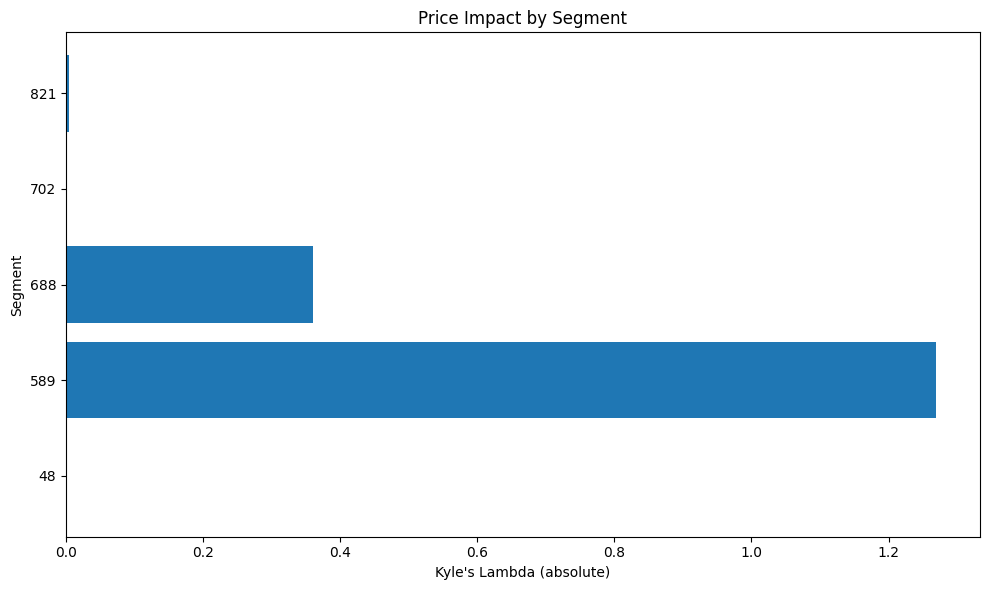

In [38]:
print('Kyle\'s Lambda by Segment:')
display(results['kyle_segment'].sort_values('lambda_abs'))

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(results['kyle_segment']['segment_id'].astype(str), results['kyle_segment']['lambda_abs'])
ax.set_xlabel('Kyle\'s Lambda (absolute)')
ax.set_ylabel('Segment')
ax.set_title('Price Impact by Segment')
plt.tight_layout()
plt.show()

## Spread Decomposition

Spread Components by Segment:


,security_id,effective_spread_bps,price_impact_bps,realized_spread_bps,adverse_selection_pct,transient_pct
segment_id,,,,,,
48,2.788279e+06,33.491706,0.000000,33.491706,0.000000,100.000000
589,2.882405e+16,7889.191864,778.809463,8528.203710,10.220642,94.046481
688,6.850000e+01,517.963763,7174.480598,7128.408877,-349.331185,-372.954010
702,1.000000e+00,1.236960,0.033055,1.203905,2.672291,97.327709
821,1.500000e+01,112.894384,179.199626,891.120567,-3.418841,35.121126


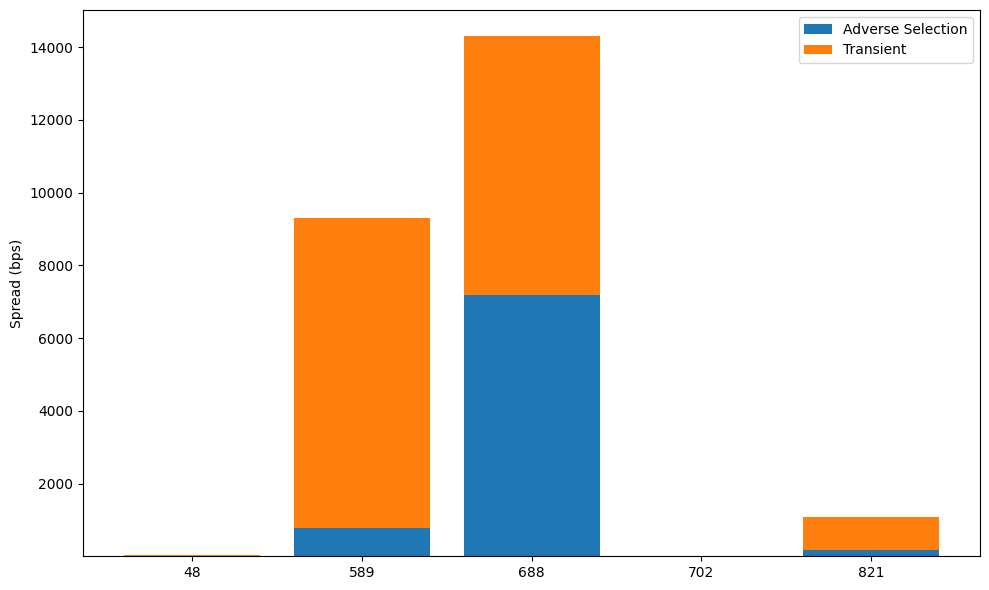

In [39]:
spread_agg = results['spread_decomp'].groupby('segment_id').mean()
print('Spread Components by Segment:')
display(spread_agg)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(spread_agg))
ax.bar(x, spread_agg['price_impact_bps'], label='Adverse Selection')
ax.bar(x, spread_agg['realized_spread_bps'], bottom=spread_agg['price_impact_bps'], label='Transient')
ax.set_xticks(x)
ax.set_xticklabels(spread_agg.index)
ax.set_ylabel('Spread (bps)')
ax.legend()
plt.tight_layout()
plt.show()

In [41]:
import duckdb
import os

DB_PATH = '/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb'
EXPORT_DIR = '/content/drive/MyDrive/00_EUREX/eurex-liquidity-demo/export_powerbi/'

# 创建导出目录
os.makedirs(EXPORT_DIR, exist_ok=True)

conn = duckdb.connect(DB_PATH)

# 导出核心表
tables = [
    'kyle_lambda_segment',
    'kyle_lambda_security', 
    'amihud_illiquidity',
    'spread_decomposition',
    'segment_summary',
    'security_summary'
]

for table in tables:
    output_file = f"{EXPORT_DIR}{table}.csv"
    conn.execute(f"COPY {table} TO '{output_file}' (HEADER, DELIMITER ',')")
    print(f"✓ Exported {table}")

conn.close()

✓ Exported kyle_lambda_segment
✓ Exported kyle_lambda_security
✓ Exported amihud_illiquidity
✓ Exported spread_decomposition
✓ Exported segment_summary
✓ Exported security_summary
